# Introduction to Quant Finance

## Module 1.7: Kalman Filters 

### 1.7.2 Kalman Filters Examples

In this module we will look at some examples of using Kalman filters in practice. We'll also start using a library for computing the Kalman filter, as it provides a more robust option than our roll-your-own solution from the previous notebook. While using a library is no guarantee that the code will be bug free, many libraries have significant effort put into their development, giving us a better likelihood of them having fewer bugs than our own code.

Let's start with a straight-forward example, which is predicting stock prices with a Kalman filter. We are going to choose a stock with a long history and a seemingly stable price, and our theory is going to be that the stock is correctly valued and any major deviations will be corrected over time.


In [47]:
%run setup.ipy

In [48]:
# You'll need to install pykalman for this notebook. Enter this into a new cell and run:

In [49]:
# !pip install simdkalman

In [50]:
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

In [51]:
stocks = quandl.get("WIKI/IBM")

In [52]:
stocks = stocks.asfreq('d')

In [53]:
close = stocks['Adj. Close']

In [54]:
close.index.inferred_freq

'D'

In [55]:
movement = close.pct_change().dropna()

(-0.1, 0.1)

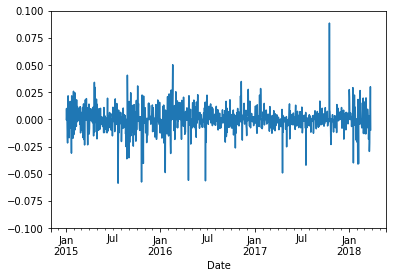

In [56]:
fig = movement["2015":].plot()
fig.set_ylim(-0.1, 0.1)  # Note there are quite a few outliers, such as a 30% drop!

In [57]:
movement.mean()  # basically 0

0.0002113122979747631

In [58]:
movement = movement - movement.mean()  # Still, demean the data

In [81]:
import simdkalman

In [82]:
kf = simdkalman.KalmanFilter(state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)

In [83]:
# smooth and explain existing data
smoothed = kf.smooth(movement)

In [84]:
smoothed.observations.mean.shape

(20538,)

In [85]:
smoothed.observations.cov.shape

(20538,)

In [86]:
smoothed.observations.mean + np.sqrt(smoothed.observations.cov)

array([1.1858614 , 1.12453956, 1.0973142 , ..., 1.10215233, 1.13272536,
       1.19455507])

In [87]:
bounds = smoothed.observations.cov
data = pd.DataFrame({"actual": movement, 
                     "smoothed": smoothed.observations.mean,
                     "upper": smoothed.observations.mean + bounds,
                     "lower": smoothed.observations.mean - bounds
                    })

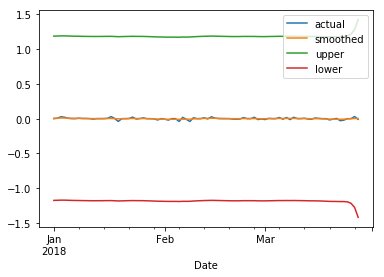

In [88]:
data["2018":].plot()

In [80]:
n_predicted = 7
predictions = kf.predict(movement, n_predicted)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 100

In [68]:
predictions.observations.mean

array([0.00354048, 0.00488494, 0.0062294 , 0.00757385, 0.00891831,
       0.01026277, 0.01160723])

In [69]:
extended_dates = pd.date_range(movement.index[-1],
                               periods=n_predicted+1, 
                              freq=movement.index.freq)[1:]

In [70]:
extended_dates[:5]

DatetimeIndex(['2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31',
               '2018-04-01'],
              dtype='datetime64[ns]', freq='D')

In [71]:
predictions_as_series = pd.Series(predictions.observations.mean,
                                 index=extended_dates)

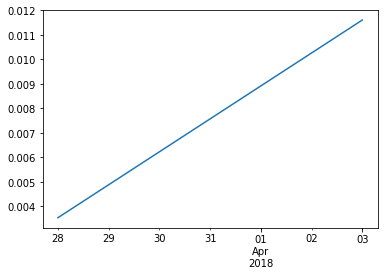

In [72]:
predictions_as_series.plot()

In [ ]:
raise ValueError

(100, 200)


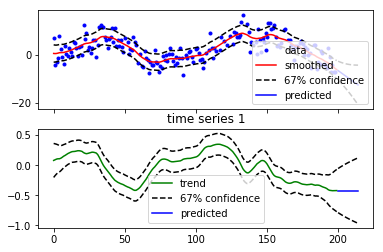

(100, 200)


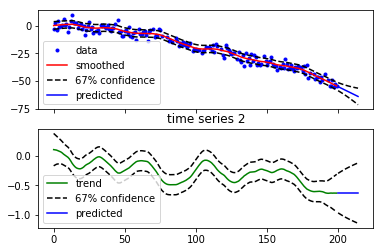

(100, 200)


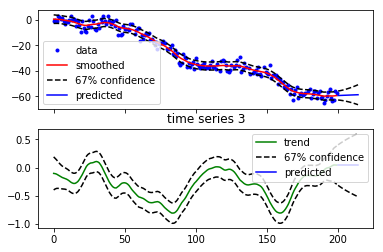

In [79]:
## Example

import simdkalman
import numpy as np
import numpy.random as random

kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)

# simulate 100 random walk time series
rand = lambda: random.normal(size=(100, 200))
data = np.cumsum(np.cumsum(rand()*0.02, axis=1) + rand(), axis=1) + rand()*3

# introduce 10% of NaNs denoting missing values
data[random.uniform(size=data.shape) < 0.1] = np.nan

# fit noise parameters to data with the EM algorithm (optional)
kf = kf.em(data, n_iter=10)

# smooth and explain existing data
smoothed = kf.smooth(data)
# predict new data
pred = kf.predict(data, 15)
# could be also written as
# r = kf.compute(data, 15); smoothed = r.smoothed; pred = r.predicted

import matplotlib.pyplot as plt

# show the first 3 smoothed time series
for i in range(3):

    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    plt.title("time series %d" % (i+1))

    x = np.arange(0, data.shape[1])

    ax1.plot(x, data[i,:], 'b.', label="data")

    smoothed_obs = smoothed.observations.mean[i,:]
    obs_stdev = np.sqrt(smoothed.observations.cov[i,:])
    print(smoothed.observations.cov.shape)
    ax1.plot(x, smoothed_obs, 'r-', label="smoothed")
    ax1.plot(x, smoothed_obs - obs_stdev, 'k--', label="67% confidence")
    ax1.plot(x, smoothed_obs + obs_stdev, 'k--')

    x_pred = np.arange(data.shape[1], data.shape[1]+pred.observations.mean.shape[1])
    y_pred = pred.observations.mean[i,:]
    pred_stdev = np.sqrt(pred.observations.cov[i,:])
    ax1.plot(x_pred, y_pred, 'b-', label="predicted")
    ax1.plot(x_pred, y_pred + pred_stdev, 'k--')
    ax1.plot(x_pred, y_pred - pred_stdev, 'k--')
    ax1.legend()

    trend = smoothed.states.mean[i,:,1]
    trend_stdev = np.sqrt(smoothed.states.cov[i,:,1,1])
    ax2.plot(x, trend, 'g-', label="trend")
    ax2.plot(x, trend - trend_stdev, 'k--', label="67% confidence")
    ax2.plot(x, trend + trend_stdev, 'k--')

    trend_pred = pred.states.mean[i,:,1]
    trend_pred_stdev = np.sqrt(pred.states.cov[i,:,1,1])
    ax2.plot(x_pred, trend_pred, 'b-', label='predicted')
    ax2.plot(x_pred, trend_pred + trend_pred_stdev, 'k--')
    ax2.plot(x_pred, trend_pred - trend_pred_stdev, 'k--')
    ax2.legend()

    plt.show()